In [4]:
import re

import nltk
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
stanza.download('pt')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2020-11-17 00:45:39 INFO: Downloading default packages for language: pt (Portuguese)...
2020-11-17 00:45:46 INFO: File exists: C:\Users\HC\stanza_resources\pt\default.zip.
2020-11-17 00:45:52 INFO: Finished downloading models and saved to C:\Users\HC\stanza_resources.


Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [23]:
def read():
    df = pd.read_csv('dataset/Covid BR Tweets/opcovidbr.csv', index_col='Id')
    return train_test_split(df, test_size=0.3, random_state=123)

def remove_urls(text):
    url_remover = re.compile(r'https?://\S+|www\.\S+')
    return url_remover.sub(r'', text)   
    
def remove_html(text):
    html_remover=re.compile(r'<.*?>')
    return html_remover.sub(r'',text)

def remove_mentions(text):
    mention_remover=re.compile(r'@\w+')
    return mention_remover.sub(r'',text)

def remove_numbers(text):
    number_remover=re.compile(r'\d+')
    return number_remover.sub(r'',text)

def remove_hashtags(text):
    number_remover=re.compile(r'#\w+')
    return number_remover.sub(r'',text)

def remove_punctuation(text):
    punct_remover=re.compile(r'[^\w\s\d]+')
    return punct_remover.sub(r'',text)

def remove_excessive_whitespace(text):
    ws_remover=re.compile(r'\s+')
    return ws_remover.sub(r' ', str(text)).strip()

def remove_stopwords(text, stop_words):
    
    
    return " ".join([word for word in text.split(" ") if word not in stop_words]) 
    
def lowering(text):
    return text.lower()

def lemmatization(text, nlp):
    doc = nlp(text)
    return ' '.join([f'{word.lemma}' for sent in doc.sentences for word in \
            sent.words])

def clean(df):
    stop_words = set(stopwords.words('portuguese'))
    df = df.loc[:,["twitter", "polarity"]]
    df = df[-df.polarity.isnull()]
    df["score"] = df.polarity   
    
    df["text"] = df.twitter        
    df["text"] = df.text.apply(lambda x: remove_urls(x))
    df["text"] = df.text.apply(lambda x: remove_mentions(x))
    df["text"] = df.text.apply(lambda x: remove_html(x))
    df["text"] = df.text.apply(lambda x: remove_numbers(x))
    df["text"] = df.text.apply(lambda x: remove_hashtags(x))
    df["text"] = df.text.apply(lambda x: remove_punctuation(x))
    df["text"] = df.text.apply(lambda x: remove_excessive_whitespace(x))
    df["text"] = df.text.apply(lambda x: remove_stopwords(x, stop_words))
    df["text"] = df.text.apply(lambda x: lowering(x))
    # Removing messages that are too short.
    df = df[df.text.apply(lambda x: len(x.split(" ")) > 2)]
    
    nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')
    
    df["text"] = df.text.apply(lambda x: lemmatization(x, nlp))
    
    
    return df

def cleaning():
    df_train, df_test = read()
    df_train = clean(df_train)
    df_test = clean(df_test)
    
    return df_train, df_test

In [24]:
df_train, df_test = cleaning()

2020-11-17 01:01:57 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |

2020-11-17 01:01:57 INFO: Use device: cpu
2020-11-17 01:01:57 INFO: Loading: tokenize
2020-11-17 01:01:57 INFO: Loading: mwt
2020-11-17 01:01:57 INFO: Loading: pos
2020-11-17 01:01:59 INFO: Loading: lemma
2020-11-17 01:01:59 INFO: Done loading processors!
2020-11-17 01:05:05 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |

2020-11-17 01:05:05 INFO: Use device: cpu
2020-11-17 01:05:05 INFO: Loading: tokenize
2020-11-17 01:05:05 INFO: Loading: mwt
2020-11-17 01:05:05 INFO: Loading: pos
2020-11-17 01:05:07 INFO: Loading: lemma
2020-11-17 01:05:08 INFO: Done loading processors!


In [25]:
# Este é o algoritmo utilizado para vetorizar os textos dos tweets
# Precisa ser o mesmo tanto no df de treino quanto no df de teste
tfidf_fitter = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5
).fit(df_train.text)
X_train = tfidf_fitter.transform(df_train.text)
y_train = df_train.score
X_test = tfidf_fitter.transform(df_test.text)
y_test = df_test.score

In [26]:
model =  LinearSVC(verbose=1, max_iter=500, 
                   penalty='l1', loss='squared_hinge',
                   dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LibLinear]

CLASSIFICATION METRICS

              precision    recall  f1-score   support

    Negativo       0.71      0.61      0.66       100
    Positivo       0.59      0.69      0.63        80

    accuracy                           0.64       180
   macro avg       0.65      0.65      0.64       180
weighted avg       0.65      0.64      0.65       180



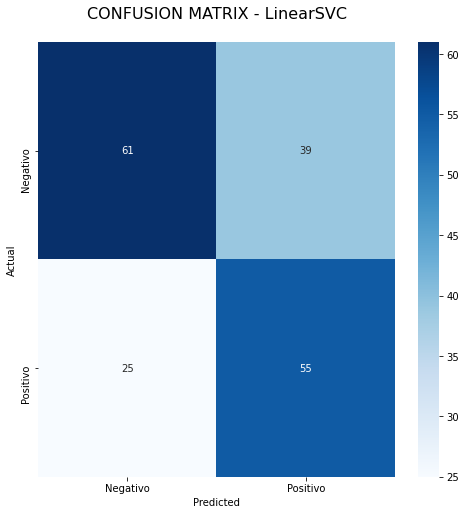

In [27]:
print('CLASSIFICATION METRICS\n')
print(classification_report(
    y_test, 
    y_pred,
    target_names=['Negativo','Positivo']
))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Negativo','Positivo'], 
            yticklabels=['Negativo','Positivo']
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);